# Statistics

# import functions

In [62]:
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx, read_isc
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from timeinfo import day_night
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, glob, datetime, gsw, cmocean, math
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



# import data

In [78]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
loki_df = export_sql('loki', 'all', 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_stb = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()]

# data pre-processing

In [107]:
# data processing for LOKI data
wm_dict = {'PS107_010-5': (70, 95), 'PS107_012-4': (70, 155), 'PS107_014-5': (50, 215), 'PS107_016-4': (100, 270)}
loki_stations = ('PS107_010-5', 'PS107_012-4', 'PS107_014-5', 'PS107_016-4')
loki_df_sel = loki_df.loc[loki_df['station'].str.contains('|'.join(loki_stations))]
print(list(loki_df_sel))
sp_col = ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']


sf_df = pd.DataFrame() # surface water mass df
aw_df = pd.DataFrame() # atlantic water mass df
adw_df = pd.DataFrame() # atlantic dense water mass df

for s in loki_stations:
    
    # count the sp with 5m depth bin
    each_st_df = loki_df_sel.loc[loki_df_sel['station'] == s]
    each_st_bin_df = pd.DataFrame(columns=sp_col)
    row = 0
    for d in range(0, math.ceil(max(each_st_df['loki_depth'])), 5):
        bin_df = each_st_df.loc[(each_st_df['loki_depth'] >= d) & (each_st_df['loki_depth'] < d+5)]
        for c in sp_col:
            if c == 'Chaetognatha' or c == 'Rhizaria': # check onlyin col = phylum
                count = bin_df['phylum'].loc[bin_df['phylum']==c].count()
                each_st_bin_df.loc[row, c] = count

            elif c == 'Ostracoda': # check onlyin col = class
                count = bin_df['class'].loc[bin_df['class']==c].count()
                each_st_bin_df.loc[row, c] = count
                
            else: # check onlyin col = genus
                count = bin_df['genus'].loc[bin_df['genus']==c].count()
                each_st_bin_df.loc[row, c] = count
        each_st_bin_df.loc[row, 'depth'] = d+5
        row += 1
        
    
    # move data to following water mass
    up, down = wm_dict[s]
    sf_df = sf_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=0) & (each_st_bin_df['depth']<up)])
    aw_df = aw_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=up) & (each_st_bin_df['depth']<down)])
    adw_df = adw_df.append(each_st_bin_df.loc[each_st_bin_df['depth']>=down])
    
sf_df.reset_index(drop=True, inplace = True)
aw_df.reset_index(drop=True, inplace = True)
adw_df.reset_index(drop=True, inplace = True)

sf_df['tag'] = 'surface'
aw_df['tag'] = 'atlantic'
adw_df['tag'] = 'atlantic_dense'

all_df = pd.concat([sf_df, aw_df, adw_df], ignore_index=True)

['vessel', 'cruise', 'station', 'region', 'latitude', 'longitude', 'bottom_depth', 'date_time', 'loki_depth', 'temperatue', 'salinity', 'oxygen', 'fluorescence', 'manual_classification', 'developmental_stage', 'area_pixel', 'area_sqrmm', 'spec_length', 'spec_width', 'image_filename', 'animal', 'copepod', 'phylum', 'class', 'spec_order', 'family', 'genus', 'species']


In [101]:
# data processing for Particle data
isc_stations = ('PS107_10_3', 'PS107_12_2', 'PS107_14_7', 'PS107_16_2')
isc_sel_stb = isc_stb.loc[isc_stb['cruise_station_haul'].str.contains('|'.join(isc_stations))]


isc_all_df = pd.DataFrame(columns=['cruise_station_cast','lat', 'lon', 'depth', 'temp', 'sal','turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
for index, value in isc_sel_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, cast, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), str(value['cruise_station_haul'].split('_')[2]),int(float(value['profile_number']))
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            lat, lon = value['lat'], value['lon']
            particle_range = [150, 500, 1000, 100000] # micro meter
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 5, particle_range, 'processed')
            df = pd.DataFrame(columns=['lat', 'lon', 'depth', 'temp', 'sal', 'turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
            df['depth'], df['sal'], df['temp']  = isc_ctd_df['Depths (m)'], isc_ctd_df['Salinity (PSU)'], isc_ctd_df['Temperature (dC)']
            df['turb'], df['fluo'] = isc_ctd_df['Turbidity (NTU)'], isc_ctd_df['Fluorescence (mg/m3)']
            df['ctd_total_vol'], df['ctd_total_abd'] = isc_ctd_df['Total Aggregate Volume (ppm)'], isc_ctd_df['Aggregate abundance (#/l)']
            df['med_ESD'], df['avg_ESD'] = isc_ctd_df['Median ESD (µm)'], isc_ctd_df['Average ESD (µm)']
            df['vol_150-500'], df['vol_500-1000'], df['vol_total'] = vol_spec_df['150-500'], vol_spec_df['500-1000'], vol_spec_df['total']
            df['abd_150-500'], df['abd_500-1000'], df['abd_total'] = aggr_con_df['150-500'], aggr_con_df['500-1000'], aggr_con_df['total']
            df['lat'], df['lon'] = lat, lon
            df['cruise_station_cast'] = str(cruise) +'_'+ str(station) +'_'+ str(cast)
            
            isc_all_df = isc_all_df.append(df, ignore_index=True)

isc_all_df = isc_all_df.dropna()

In [102]:
# tag water mass name on the particle data frame
wm_isc_dict = {'PS107_10_3': (70, 95), 'PS107_12_2': (70, 155), 'PS107_14_7': (50, 215), 'PS107_16_2': (100, 270)}

for key in wm_isc_dict:
    up, down = wm_isc_dict[key]
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>0) & (isc_all_df['depth']<=up) ,'tag'] = 'surface'
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>up) & (isc_all_df['depth']<=down) ,'tag'] = 'atlantic'
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>down),'tag'] = 'atlantic_dense'


# vertical distribution, both Paticle and Zooplankton

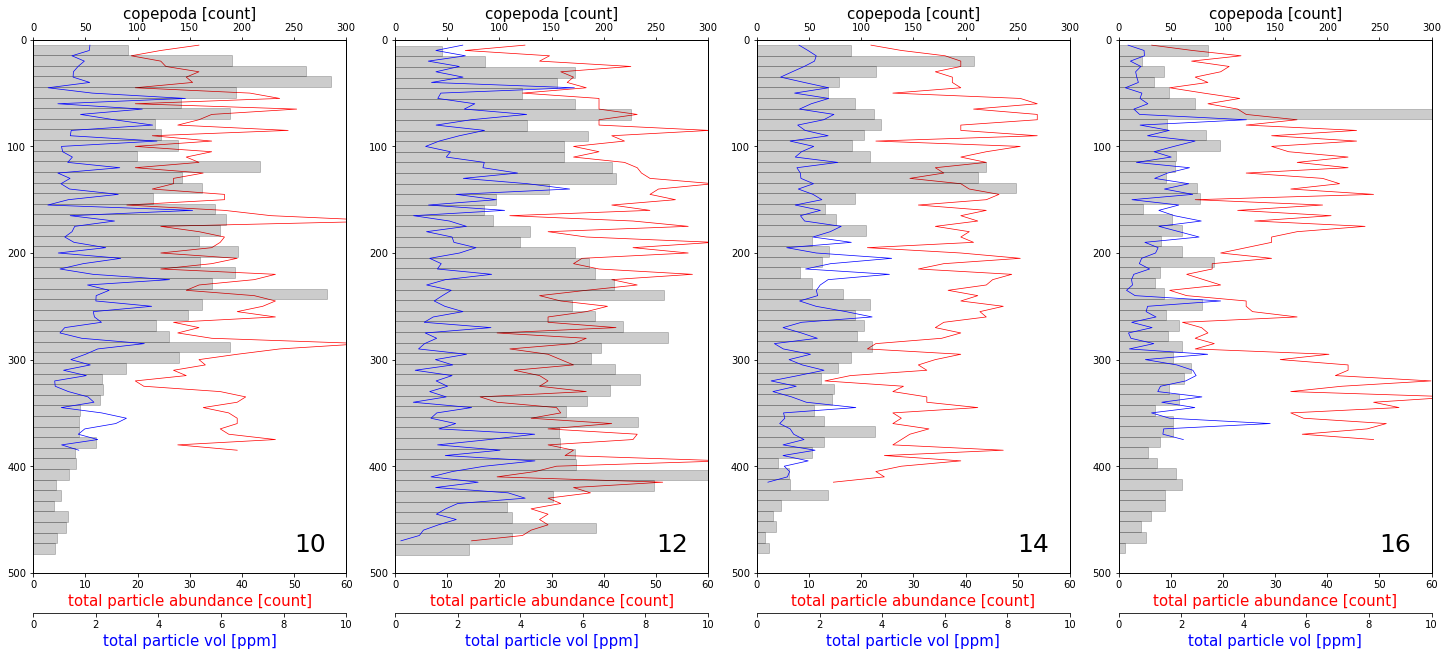

In [128]:
# Based on the cruise and profilenumber of ISC, import data from excel file
fig = plt.figure(constrained_layout=True, figsize =(20, 9))
gs = fig.add_gridspec(1, 4)

n = 0
for i in isc_stations:
    cruise, station = i.split('_')[0], i.split('_')[1]
    #  from here specific station
    isc_station_df = isc_all_df.loc[isc_all_df['cruise_station_cast'] == i]
    loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
    
    copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
    copepoda_depth = copepoda_df['loki_depth'].to_list()
    
    ax = fig.add_subplot(gs[0,n])
    ax.plot(isc_station_df['abd_total'], isc_station_df['depth'], color='red', linewidth= 0.7)
    ax.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
    ax.set_ylim(0,500)
    ax.set_xlim(0,60)

    sec_axs = ax.twiny()
    sec_axs.hist(copepoda_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.2, color='black')
    sec_axs.set_xlim(0,300)
    sec_axs.set_xlabel('copepoda [count]', color = 'black', fontsize=15)


    thr_axs = ax.twiny()
    thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
    thr_axs.xaxis.set_ticks_position('bottom')
    thr_axs.xaxis.set_label_position('bottom')
    thr_axs.plot(isc_station_df['vol_150-500']+isc_station_df['vol_500-1000'], isc_station_df['depth'], color='blue', linewidth= 0.7)
    thr_axs.set_xlabel('total particle vol [ppm]', color = 'blue', fontsize=15)
    thr_axs.set_xlim(0,10)
    thr_axs.invert_yaxis()
    
    ax.text(50, 480, station, size=25)
    
    n += 1

plt.show()
plt.close()


# Linear Discriminant analysis

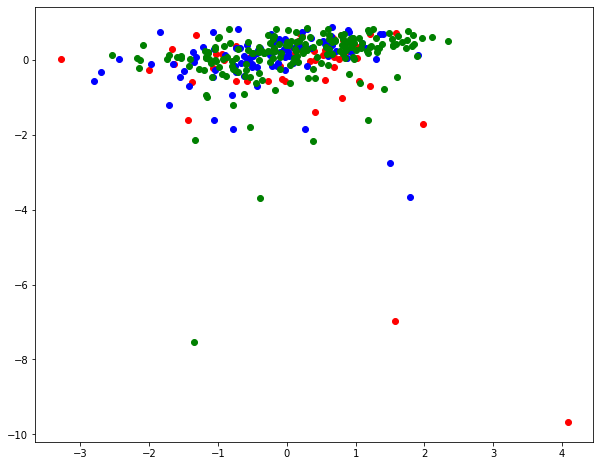

In [129]:
# LOKI zooplankton
# normalise data

isc_sel_df = isc_all_df[['abd_150-500','abd_500-1000','abd_total', 'vol_150-500','vol_500-1000','vol_total','avg_ESD', 'tag']]
all_df_scaled = StandardScaler().fit_transform(isc_sel_df[['abd_total', 'vol_total', 'avg_ESD']])

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, isc_sel_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
fig = plt.figure(figsize =(10, 8))

plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c='red')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c='blue')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c='green')

plt.show()
plt.close()

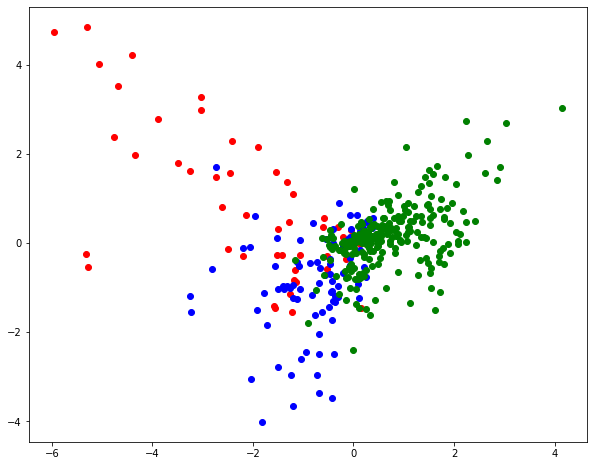

In [130]:
# LOKI zooplankton
# normalise data
all_df_scaled = StandardScaler().fit_transform(all_df[['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']])


lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, all_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
fig = plt.figure(figsize =(10, 8))

plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c='red')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c='blue')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c='green')

plt.show()
plt.close()